Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3316
           1       1.00      1.00      1.00      3239

    accuracy                           1.00      6555
   macro avg       1.00      1.00      1.00      6555
weighted avg       1.00      1.00      1.00      6555

Confusion Matrix:
[[3314    2]
 [   0 3239]]


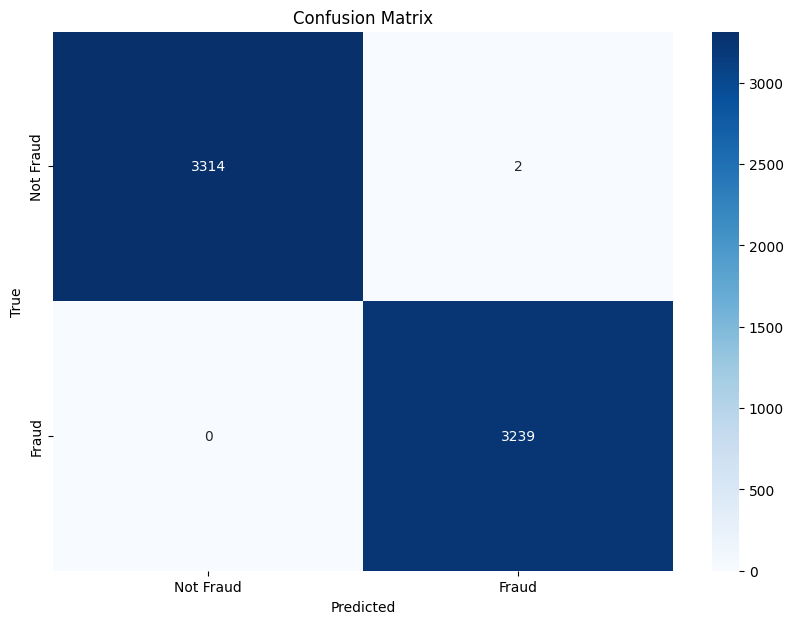

Prediction for input_values: Not Fraud


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the provided Excel file to inspect its contents
file_path = 'Transparency_balanced.xlsx'
xls = pd.ExcelFile(file_path)

# Check sheet names and load data from the first sheet
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Prepare the dataset (dropping unnecessary columns and handling categorical variables)
df_prepared = df.drop(['nameOrig', 'nameDest'], axis=1)
df_prepared = pd.get_dummies(df_prepared, columns=['type'], drop_first=True)

# Define the feature columns and target (isFraud)
X = df_prepared.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_prepared['isFraud']

# Split the dataset into 3 different "clients" (for federated learning simulation)
X_client1, X_temp, y_client1, y_temp = train_test_split(X, y, test_size=0.66, random_state=42)
X_client2, X_client3, y_client2, y_client3 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a function to train a RandomForestClassifier for a client
def train_on_client(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Train models for each client
model_client1 = train_on_client(X_client1, y_client1)
model_client2 = train_on_client(X_client2, y_client2)
model_client3 = train_on_client(X_client3, y_client3)

# Simulating a basic federated averaging by averaging the predictions of the models
def federated_averaging(models, X):
    # Collect predictions from all models
    predictions = np.mean([model.predict_proba(X) for model in models], axis=0)
    return np.argmax(predictions, axis=1)

# Define a function to evaluate the model performance
def evaluate_model(X_test, y_test, models):
    y_pred = federated_averaging(models, X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Split the original dataset into a final train and test set for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train models on the entire training set for final evaluation
model_final_client1 = train_on_client(X_train, y_train)
model_final_client2 = train_on_client(X_train, y_train)
model_final_client3 = train_on_client(X_train, y_train)

# Evaluate the models
evaluate_model(X_test, y_test, [model_final_client1, model_final_client2, model_final_client3])

# Function to predict fraud dynamically based on user input
def predict_fraud(input_data):
    # Ensure the input_data has the correct shape and features
    input_df = pd.DataFrame([input_data])
    input_df = pd.get_dummies(input_df, columns=['type'], drop_first=True)
    
    # Align input_df columns with the model training data columns
    missing_cols = set(X.columns) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0  # Add missing columns and fill with 0
    
    input_df = input_df[X.columns]  # Reorder columns to match the training set
    
    # Federated averaging to predict the outcome
    models = [model_client1, model_client2, model_client3]
    prediction = federated_averaging(models, input_df)
    
    return "Fraud" if prediction[0] == 1 else "Not Fraud"

# Example input values for dynamic prediction
input_values = {
    "step": 1,
    "type": "TRANSFER",  # Example: "TRANSFER", "CASH_OUT", etc.
    "amount": 1000.0,
    "oldbalanceOrg": 1500.0,
    "newbalanceOrig": 500.0,
    "oldbalanceDest": 0.0,
    "newbalanceDest": 1000.0
}

# Predict dynamically
fraud_prediction = predict_fraud(input_values)
print(f"Prediction for input_values: {fraud_prediction}")


In [14]:
# Example input values for dynamic prediction
input_values = {
    "step": 1,
    "type": "TRANSFER",  # Example: "TRANSFER", "CASH_OUT", etc.
    "amount": 25071.46,
    "oldbalanceOrg": 25071.46,
    "newbalanceOrig": 0,
    "oldbalanceDest": 0,
    "newbalanceDest": 0
}

# Predict dynamically
fraud_prediction = predict_fraud(input_values)
print(f"Prediction for input_values: {fraud_prediction}")

Prediction for input_values: Fraud
